In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import re
import pandas as pd
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.utils import plot_model

tweetsTrain = pd.read_json('trainData.json')
tweetsTest = pd.read_json('testData.json')


def form_sentence(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", '', tweet)
    tweet = re.sub(r'<[^>]+>', '', tweet)
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess


def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet


Final_words = []
for data in tweetsTrain['Content']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words.append(word_Final)

final_bodyTrain = pd.DataFrame(Final_words, columns=['Content'])
print(final_bodyTrain['Content'])

Final_wordss = []
for data in tweetsTest['Content']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_wordss.append(word_Final)

final_bodyTest = pd.DataFrame(Final_wordss, columns=['Content'])

0                                 Went see yesterday cool
1                                                        
2                                        mento movie ever
3                      Nick like like suspense whole time
4                                  go see girl girls rock
                              ...                        
4857    lot brand feature see Atari surprise connectio...
4858                 IMAX worth scenes shoot IMAX cameras
4859    probably READING WAY MUCH might little bite po...
4860                                                 mean
4861         Solid little Loved fall Oscar statue well do
Name: Content, Length: 4862, dtype: object


In [4]:
vocab_size = 5000
embedding_dim = 64
# max_length = 10
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [5]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(final_bodyTrain['Content'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_length = max([len(s) for s in final_bodyTrain['Content']])
print(max_length)

5553
207


In [6]:
dict(list(word_index.items())[10:11])

{'amp': 11}

In [7]:
train_sequences = tokenizer.texts_to_sequences(final_bodyTrain['Content'])

In [8]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
print(len(train_sequences))
print(train_padded.shape)
print(train_sequences[10])
print(train_padded[10])

4862
(4862, 207)
[319]
[319   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


In [10]:
validation_sequences = tokenizer.texts_to_sequences(final_bodyTest['Content'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

580
(580, 207)


In [11]:
print(set(tweetsTrain['Sentiment']))

{'Positive', 'Negative', 'Neutral'}


In [12]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(tweetsTrain['Sentiment'])

training_label_seq = np.array(label_tokenizer.texts_to_sequences(tweetsTrain['Sentiment']))

# from sklearn import preprocessing
# from keras.utils import to_categorical

# label_encoder = preprocessing.LabelEncoder()
# y_train = label_encoder.fit_transform(tweetsTrain['Sentiment'])

# y_test = label_encoder.fit_transform(tweetsTest['Sentiment'])

# training_label_seq = to_categorical(y_train)
# validation_label_seq = to_categorical(y_test)

In [45]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(tweetsTest['Sentiment'])

validation_label_seq = np.array(label_tokenizer.texts_to_sequences(tweetsTest['Sentiment']))

In [47]:
from keras.regularizers import l2
from tensorflow.python.keras.callbacks import EarlyStopping

embedding_dim = 64
callback = EarlyStopping(monitor='val_loss')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-6)),
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 207, 64)           355392    
_________________________________________________________________
flatten_3 (Flatten)          (None, 13248)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               1695872   
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 774       
Total params: 2,052,038
Trainable params: 2,052,038
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), callbacks=[callback], verbose=2)

Epoch 1/10
152/152 - 4s - loss: 0.8792 - accuracy: 0.5899 - val_loss: 0.5712 - val_accuracy: 0.7914
Epoch 2/10
152/152 - 4s - loss: 0.3085 - accuracy: 0.8891 - val_loss: 0.6562 - val_accuracy: 0.8052


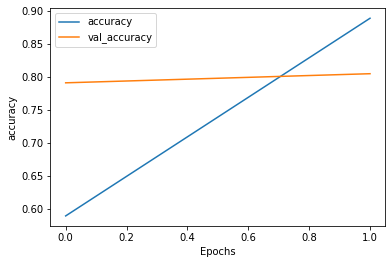

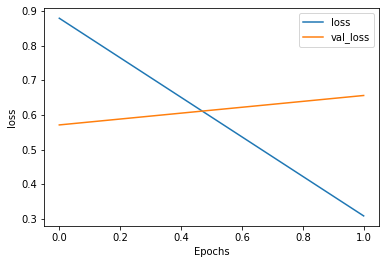

In [50]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [51]:
loss, accuracy = model.evaluate(validation_padded, validation_label_seq)
print('Accuracy: %f' % (accuracy*100))

19/19 [==============================] - 0s 7ms/step - loss: 0.6562 - accuracy: 0.8052
Accuracy: 80.517244


In [52]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

x=[validation_padded]
# predict probabilities for test set
yhat_probs = model.predict(x, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(validation_label_seq, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(validation_label_seq, yhat_classes, average = 'weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(validation_label_seq, yhat_classes, average = 'weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(validation_label_seq, yhat_classes, average = 'weighted')
print('F1 score: %f' % f1)

confusion_matrix = confusion_matrix(validation_label_seq, yhat_classes)
print(confusion_matrix)
negative = confusion_matrix[2][2]
print(confusion_matrix[1][1])
print(negative)

Accuracy: 0.805172
Precision: 0.814375
Recall: 0.805172
F1 score: 0.795546
[[279  20   1]
 [ 88 111   1]
 [  1   2  77]]
111
77


In [53]:
model.save('lstm_model.h5')

In [ ]:
BlackPanther = pd.read_json('BlackPanther.json')

Final_words = []
for data in BlackPanther['Content']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words.append(word_Final)

final_BlackPanther = pd.DataFrame(Final_words, columns=['Content'])

BlackPanther_tokens = tokenizer_obj.texts_to_sequences(final_BlackPanther)
BlackPanther_pad = pad_sequences(BlackPanther_tokens, maxlen = max_length, padding = 'post')
print(final_BlackPanther)

In [ ]:
from keras.models import load_model
# CATEGORIES = ['Neutral', 'Negative', 'Positive']
model = load_model('lstm_model.h5')

In [ ]:
predict = model.predict_proba(BlackPanther_pad, verbose=0)
# predict crisp classes for test set
print(predict)
# yhat_classes = np.argmax(yhat_probs,axis=1)

# reduce to 1d array
# yhat_probs = yhat_probs[:, 0]
# confusion_matrix = confusion_matrix(yhat_classes)
# print(confusion_matrix)